This notebook shows an example of the use of the kalman filter without the camera

In [ ]:
import tdmclient.notebook
from Kalman import ekf
import time

In [2]:
await tdmclient.notebook.start()

In [3]:
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.4375# value found in covariance_estimation
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.4375 # value found in covariance_estimation
    
    difference_speed = l_speed-r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega

def get_velocity_vector(r_speed,l_speed):
    v=speed_convesion(r_speed,l_speed)
    w=angular_vel_conversion(r_speed,l_speed)
    return v,w


In [ ]:
time_prev = time.time()


input_right_speed=60
input_left_speed=40

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False
set_speed(input_right_speed,input_left_speed)

input_v = speed_convesion(input_right_speed,input_left_speed) #[mm/s]
input_w = angular_vel_conversion(input_right_speed,input_left_speed) #[rad/s]
control_vect=[input_v,input_w]


x_est=[0,0,0,0,0]
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_reached=False

 ### -----Plots----
x_est_vect=[]
y_est_vect=[]
yaw_est_vect=[]
x_est_vect.append(x_est[0])
y_est_vect.append(x_est[1])
yaw_est_vect.append(x_est[2])


x_pred_vect=[]
y_pred_vect=[]
yaw_pred_vect=[]
x_pred_vect.append(0)
y_pred_vect.append(0)
yaw_pred_vect.append(0)
### ------------


while not goal_reached:
    actual_time = time.time()
    Ts = actual_time - time_prev
    if Ts < 0.05:
        time.sleep(0.05-Ts)
        Ts=0.05
        actual_time = time.time()

    time_prev = actual_time
    v_right_odo, v_left_odo=get_speed()

    actual_v = speed_convesion(v_right_odo,v_left_odo)
    actual_w = angular_vel_conversion(v_right_odo,v_left_odo)
    obs_odometry=[actual_v,actual_w]

    x_est, P_est = ekf(x_est, control_vect, P_est, obs_camera, obs_odometry, camera_state, Ts)
    

    ### -----Plots----
    x_est_vect.append(x_est[0])
    y_est_vect.append(x_est[1])
    yaw_est_vect.append(x_est[2])
    ### -------------

    # ------ calculation to compare with odometry -----
    
    x, y, yaw, v, omega = x_est

    x_pred = x + Ts * v * np.cos(yaw)
    y_pred = y + Ts * v * np.sin(yaw)
    yaw_pred = yaw + Ts * omega

    x_pred_vect.append(x_pred)
    y_pred_vect.append(y_pred)
    yaw_pred_vect.append(yaw_pred)

    print(f"x = {x_est[0]}, y {x_est[1]}, yaw deg {x_est[2]*180/np.pi}")
    # if x_est[2]<=-np.pi/2:
    if x_est[2]<=-np.pi:
        goal_reached=True
        stop_thymio()

x = 0.0, y 0.0, yaw deg 0.0
x = 0.9750000000000001, y 0.0, yaw deg -0.23276410427189695
x = 1.9499919543567685, y -0.003960926604852131, yaw deg -0.4655282085437939
x = 2.924959771916627, y -0.011882714443884949, yaw deg -0.6982923128156908
x = 3.8998873619242476, y -0.023765232776834434, yaw deg -0.9310564170875878
x = 4.874758634288213, y -0.03960828549600172, yaw deg -1.1638205213594848
x = 5.849557499846567, y -0.05941161112948963, yaw deg -1.3965846256313816
x = 6.824267870632346, y -0.08317488284551797, yaw deg -1.6293487299032787
x = 7.798873660139093, y -0.11089770845781752, yaw deg -1.8621128341751756
x = 8.77335878358635, y -0.14257963043210264, yaw deg -2.0948769384470722
x = 9.747707158185115, y -0.1782201258936224, yaw deg -2.327641042718969
x = 10.721902703403277, y -0.21781860663578995, yaw deg -2.560405146990866
x = 11.695929341231, y -0.2613744191298903, yaw deg -2.793169251262763
x = 12.669770996446077, y -0.30888684453586607, yaw deg -3.0259333555346597
x = 13.643411

KeyboardInterrupt: 

In [ ]:
stop_thymio()


Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\jcarr\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\jcarr\anaconda3\Lib\site-packages\tdmclient\tcp.py", line 73, in run
    packet = self.read_packet()
             ^^^^^^^^^^^^^^^^^^
  File "c:\Users\jcarr\anaconda3\Lib\site-packages\tdmclient\tcp.py", line 66, in read_packet
    raise error
  File "c:\Users\jcarr\anaconda3\Lib\site-packages\tdmclient\tcp.py", line 59, in read_packet
    packet_len = self.read_uint32()
                 ^^^^^^^^^^^^^^^^^^
  File "c:\Users\jcarr\anaconda3\Lib\site-packages\tdmclient\tcp.py", line 46, in read_uint32
    b = self.io.read(4)
        ^^^^^^^^^^^^^^^
  File "c:\Users\jcarr\anaconda3\Lib\site-packages\tdmclient\tcp.py", line 99, in read
    return self.socket.recv(n)
           ^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant


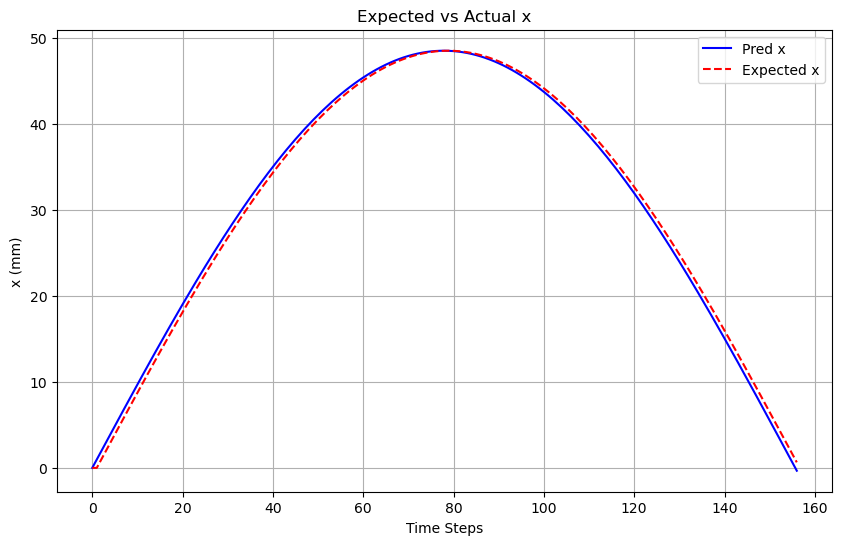

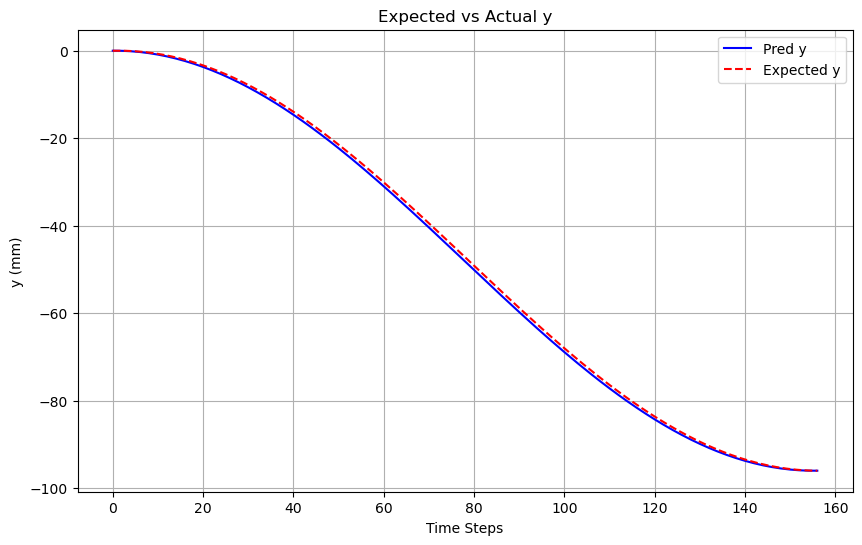

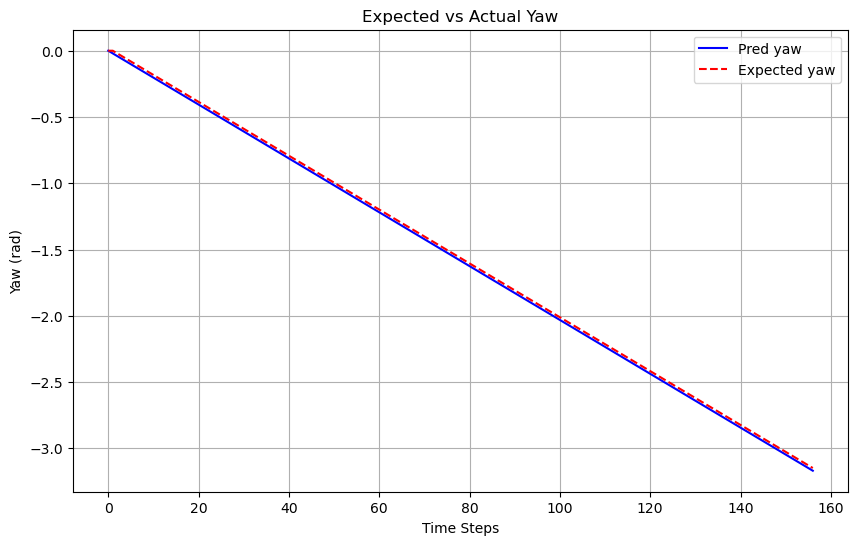

In [ ]:

# Plot 1: Expected vs. Actual x
plt.figure(figsize=(10, 6))
plt.plot(range(len(x_pred_vect)), x_pred_vect, label="Pred x", color='blue')
plt.plot(range(len(x_est_vect)), x_est_vect, label="Expected x", linestyle='--', color='red')
plt.xlabel("Time Steps")
plt.ylabel("x (mm)")
plt.title("Expected vs Actual x")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Expected vs. Actual y
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_pred_vect)), y_pred_vect, label="Pred y", color='blue')
plt.plot(range(len(y_est_vect)), y_est_vect, label="Expected y", linestyle='--', color='red')
plt.xlabel("Time Steps")
plt.ylabel("y (mm)")
plt.title("Expected vs Actual y")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Expected vs. Actual yaw
plt.figure(figsize=(10, 6))
plt.plot(range(len(yaw_pred_vect)), yaw_pred_vect, label="Pred yaw", color='blue')
plt.plot(range(len(yaw_est_vect)), yaw_est_vect, label="Expected yaw", linestyle='--', color='red')
plt.xlabel("Time Steps")
plt.ylabel("Yaw (rad)")
plt.title("Expected vs Actual Yaw")
plt.legend()
plt.grid()
plt.show()
